# Primera carga de datos y EDA
Cargar con pandas los datos, ver las primeras filas.

In [8]:
import pandas as pd

Cargar el csv con los datos

In [9]:
df = pd.read_csv("../data/diabetes.csv")

Imprimir datos

In [11]:
print(df.shape)


(768, 9)


In [12]:
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [13]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [14]:
print(df.describe())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [15]:
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


# Importar librerías para los gráficos

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

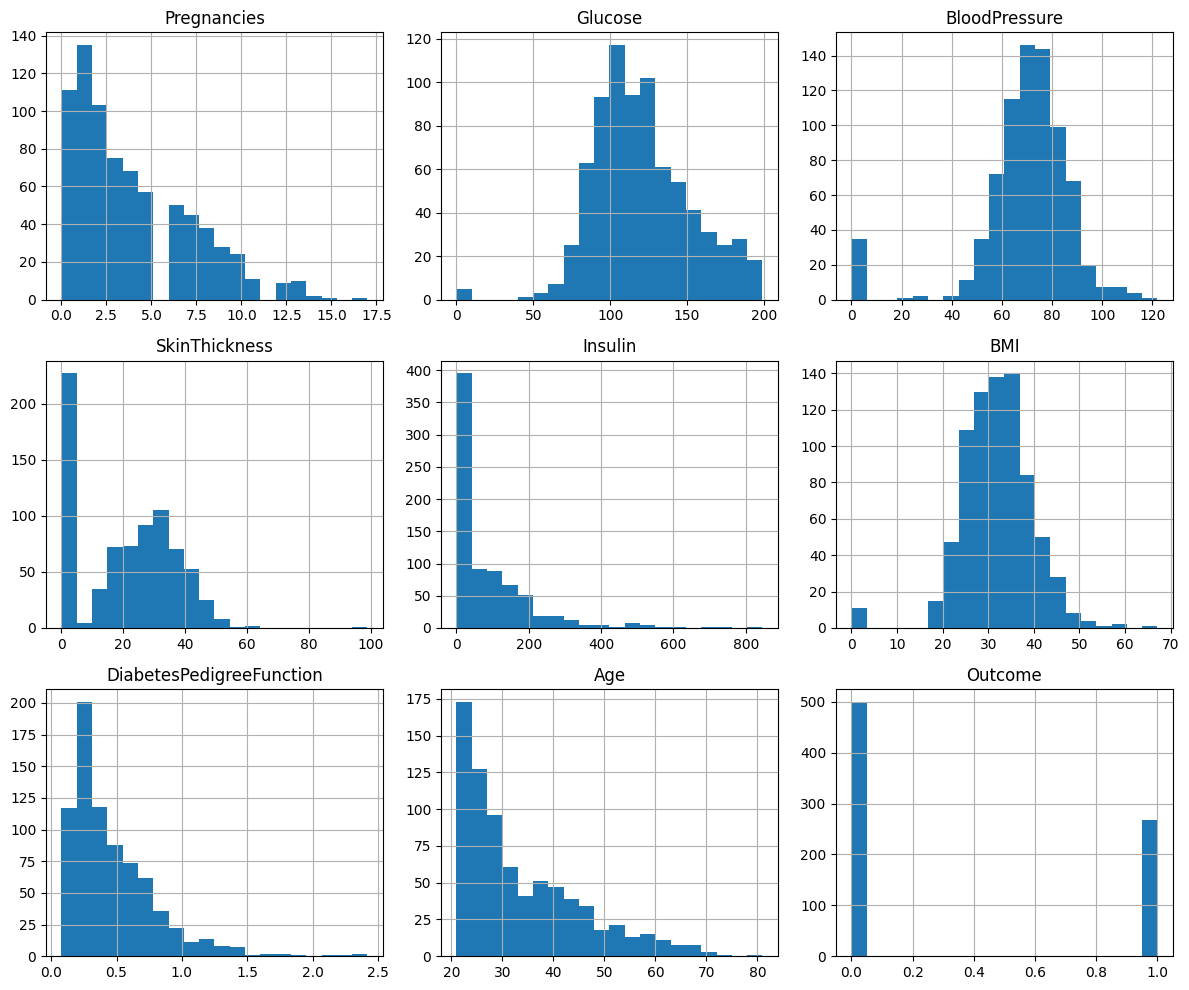

In [19]:
# Histogramas de todas las variables
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

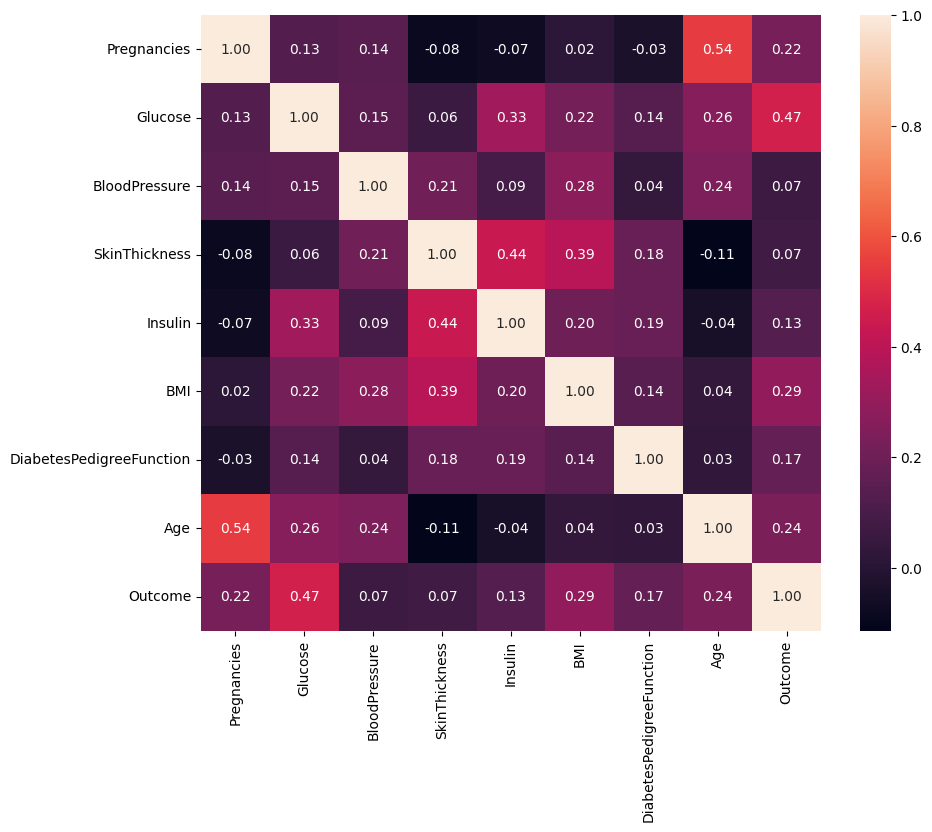

In [20]:
# Gráfico de mapa de calor para visualizar la correlación entre variables
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

# Realizar limpieza 
Se necesitan tratar los valores de 0 que representan un missing

In [23]:
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in cols_with_zero:
    df[col].replace(0, pd.NA, inplace=True)
    # imputar con mediana
    df[col].fillna(df[col].median(), inplace=True)

Se hace esta limpieza por el motivo de que ciertas columnas usan 0 como faltante (Glucose, BloodPressure, SkinThickness, Insulin, BMI).

# Hacer la separación dde caracterísiticas de train y target

In [24]:
# Imoportar la librería 
from sklearn.model_selection import train_test_split

In [25]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline de preprocesamiento

Se hace el escalado de las variables numéricas.

In [27]:
# importar librerías
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [28]:
preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Entrenamiento de modelos
Regresion logística y KNN

In [29]:
# importar librerías para modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [30]:
# Regresión logística con Pipeline
pipe_log = Pipeline([
    ('preproc', preproc),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [31]:
param_grid_log = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

In [32]:
gs_log = GridSearchCV(pipe_log, param_grid_log, cv=5, scoring='f1', n_jobs=-1)
gs_log.fit(X_train, y_train)
print("Mejor Logistic:", gs_log.best_params_, "CV best score:", gs_log.best_score_)

Mejor Logistic: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} CV best score: 0.6496858824779203


Ahora con KNN


In [33]:
# KNN con Pipeline
pipe_knn = Pipeline([
    ('preproc', preproc),
    ('clf', KNeighborsClassifier())
])

In [34]:
param_grid_knn = {'clf__n_neighbors': [3,5,7,9]}
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
gs_knn.fit(X_train, y_train)
print("Mejor KNN:", gs_knn.best_params_, "CV best score:", gs_knn.best_score_)

Mejor KNN: {'clf__n_neighbors': 7} CV best score: 0.6325029966219897


# Evaluar el conjunto de prueba

Se calculará Accuracy, precision, recall, f1-score, matriz de confusión, ROC & AUC

In [35]:
# Importar librerías para la evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

In [39]:
def evaluar_modelo(model, X_test, y_test, nombre="modelo"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print("===", nombre, "===")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test,y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr,tpr, label=f'AUC={roc_auc_score(y_test,y_proba):.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC {nombre}")
    plt.legend()
    plt.show()

=== Logistic (GridSearch) ===
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Accuracy: 0.7077922077922078
AUC: 0.812962962962963
Confusion matrix:
 [[82 18]
 [27 27]]


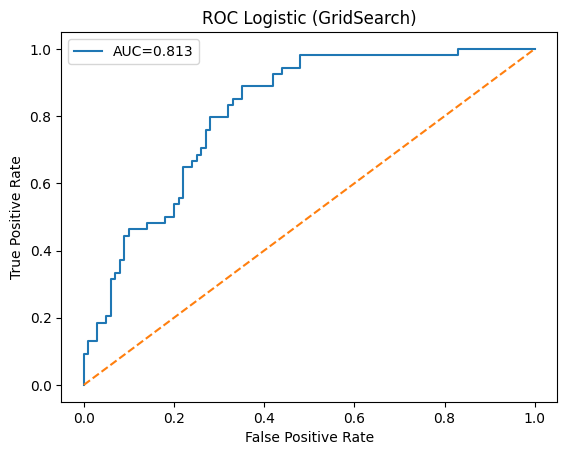

In [ ]:
# Evaluar el modelo con Logistica
evaluar_modelo(gs_log.best_estimator_, X_test, y_test, "Logistic") 


=== KNN ===
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154

Accuracy: 0.7272727272727273
AUC: 0.7900000000000001
Confusion matrix:
 [[82 18]
 [24 30]]


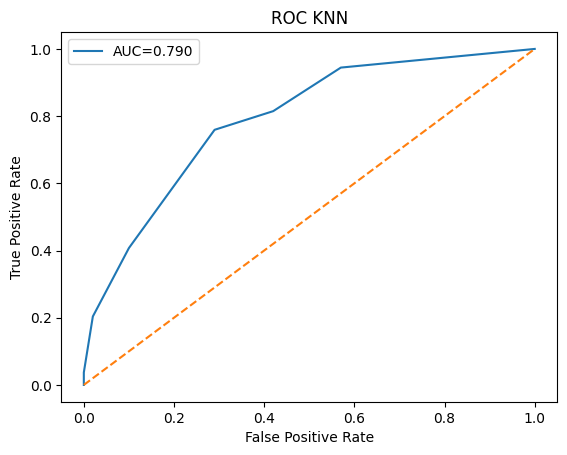

In [42]:
# Evaluar con KNN
evaluar_modelo(gs_knn.best_estimator_, X_test, y_test, "KNN")

El mejor modelo fue el KNN, ya que, en un diagnóstico médico suele ser más grave cometer un flaso negativo (FN), que un flaso positivo (FP)

Ejemplo de caso de falso negativo:
Decirle a un paciente que sí tiene diabetes que está sano. El paciente no recibe el tratamiento.

Ejemplo de caso de falso positivo:
Decirle a un paciente que está sano que tiene diabetes. El paciente se hará pruebas posteriores, pero es menos riesgoso que omitir un diagnóstico.

Una métrica que es clave para decidir es el Recall o la sensibilidad, que midió la capacidad del modelo para encontrar a los pacientes que realmente son positivos (Clase 1). Encontró al 56% de los pacientes diabéticos, mientras que en logpistica, se encontró sólo el 50% de ellos con diabetes, lo que justifica el argumento de arriba.